In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [9]:
# Carregar o dataset de avaliações da Sephora
sephora_data = pd.read_csv('sephora_reviews.csv')  # Certifique-se de ter o caminho correto do arquivo

# Inicializar o modelo SBERT
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Combinar as colunas relevantes para criar uma entrada de texto única para cada avaliação
# Supondo que `review_text` seja a coluna com o texto principal da avaliação.
# Ajuste o código caso o dataset tenha colunas adicionais relevantes.
sephora_data['combined_text'] = sephora_data['Review']  # Use as colunas relevantes, se houver mais

# Gerar embeddings para cada texto combinado usando SBERT
embeddings = model.encode(sephora_data['combined_text'].tolist(), convert_to_tensor=True)

# Salvar embeddings em um arquivo para uso posterior
torch.save(embeddings, 'sephora_embeddings.pt')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

# Carregar embeddings salvos anteriormente
embeddings_tensor = torch.load('sephora_embeddings.pt')  # Carregar o arquivo de embeddings
embeddings_tensor = embeddings_tensor.float()  # Garantir que esteja em float

# Definir o modelo de Autoencoder
class EmbeddingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128):
        super(EmbeddingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded


# Definir as dimensões
input_dim = embeddings_tensor.shape[1]  # Ajusta automaticamente ao tamanho dos embeddings
hidden_dim = 128  # Dimensão reduzida para ajuste fino


# Inicializar o modelo, otimizador e função de perda
autoencoder = EmbeddingAutoencoder(input_dim, hidden_dim)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Loop de treinamento
epochs = 30
for epoch in range(epochs):
    optimizer.zero_grad()
    decoded, encoded = autoencoder(embeddings_tensor)
    loss = criterion(decoded, embeddings_tensor)  # Perda de reconstrução
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Extrair os embeddings ajustados
fine_tuned_embeddings = encoded.detach().numpy()


<ipython-input-43-2cf2198af3d1>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_tensor = torch.load('sephora_embeddings.pt')  # Carregar o arquivo de embeddings


Epoch 1/30, Loss: 0.08417976647615433
Epoch 2/30, Loss: 0.08194652199745178
Epoch 3/30, Loss: 0.07978697121143341
Epoch 4/30, Loss: 0.07733000814914703
Epoch 5/30, Loss: 0.07430217415094376
Epoch 6/30, Loss: 0.07064195722341537
Epoch 7/30, Loss: 0.06647304445505142
Epoch 8/30, Loss: 0.062262434512376785
Epoch 9/30, Loss: 0.05902114138007164
Epoch 10/30, Loss: 0.057496968656778336
Epoch 11/30, Loss: 0.05583830550312996
Epoch 12/30, Loss: 0.05311289802193642
Epoch 13/30, Loss: 0.050319138914346695
Epoch 14/30, Loss: 0.04827018082141876
Epoch 15/30, Loss: 0.04700974375009537
Epoch 16/30, Loss: 0.046172332018613815
Epoch 17/30, Loss: 0.04543576389551163
Epoch 18/30, Loss: 0.04470384865999222
Epoch 19/30, Loss: 0.04405413568019867
Epoch 20/30, Loss: 0.043599046766757965
Epoch 21/30, Loss: 0.043331775814294815
Epoch 22/30, Loss: 0.04309803619980812
Epoch 23/30, Loss: 0.04277217388153076
Epoch 24/30, Loss: 0.04239174723625183
Epoch 25/30, Loss: 0.04206104576587677
Epoch 26/30, Loss: 0.0418186

In [44]:
# Save fine-tuned embeddings for later use
np.save('fine_tuned_embeddings.npy', fine_tuned_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


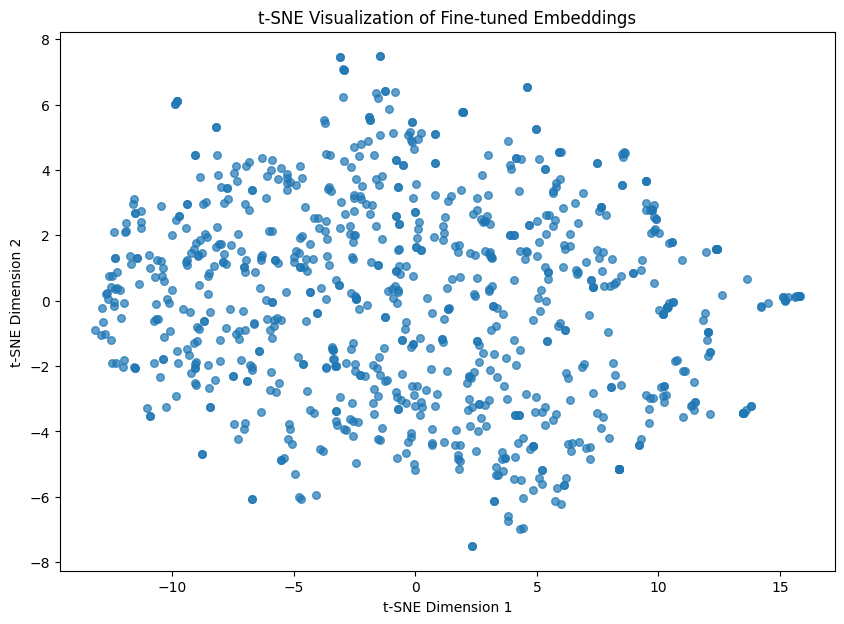

In [45]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embeddings_2d = tsne.fit_transform(fine_tuned_embeddings)

# Create a scatter plot of the 2D embeddings
plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=30, alpha=0.7)

# Optionally, add labels or a color scheme if you have categories (e.g., sport type)
plt.title("t-SNE Visualization of Fine-tuned Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [46]:
from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 10  # You can adjust this based on your data and visualization

# Initialize and fit K-Means on the 2D embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_2d)

# Add the cluster labels to your data for easy analysis
sephora_data['Cluster'] = cluster_labels


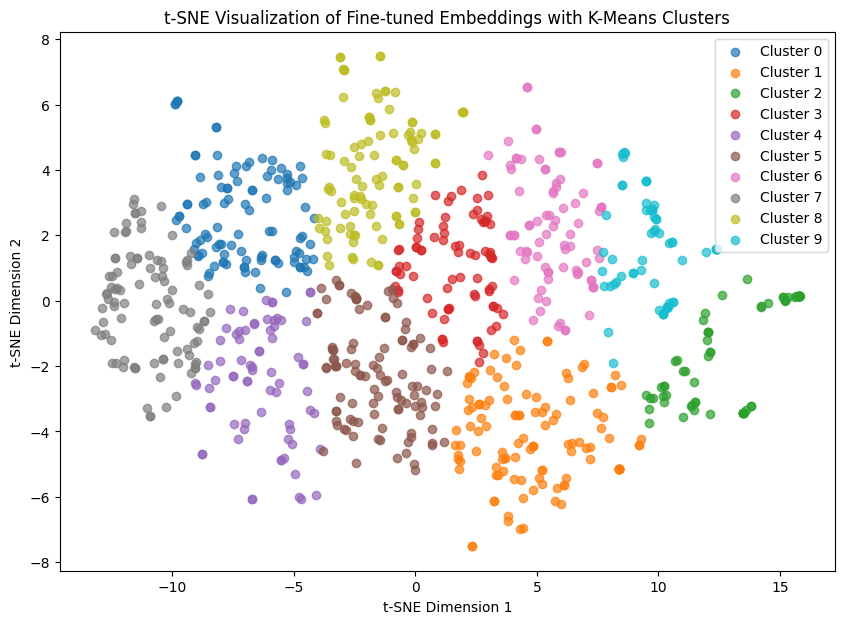

In [47]:
# Create a scatter plot with clusters
plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    # Filter data points for the current cluster
    cluster_points = embeddings_2d[sephora_data['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.7)

plt.legend(loc='best')
plt.title("t-SNE Visualization of Fine-tuned Embeddings with K-Means Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Lista básica de stop words em português
stop_words_pt = [
    "a", "o", "e", "é", "de", "da", "do", "em", "um", "uma", "para", "com", "não", "que", "se",
    "no", "na", "por", "mais", "os", "as", "dos", "das", "foi", "ser", "tem", "são", "como",
    "também", "pelo", "pela", "até", "nos", "nas", "isso", "ou", "ele", "ela", "entre", "eles",
    "elas", "mesmo", "seu", "sua", "seus", "suas"
]

# Definir o número de clusters (assumindo que você já tem essa informação)
n_clusters = sephora_data['Cluster'].nunique()

# Criar o vetor TF-IDF com a lista de stop words em português
vectorizer = TfidfVectorizer(stop_words=stop_words_pt, max_features=20)

# Extrair e exibir as principais palavras-chave para cada cluster
for cluster in range(n_clusters):
    cluster_texts = sephora_data[sephora_data['Cluster'] == cluster]['Review']  # Ajuste o nome da coluna se necessário
    tfidf_matrix = vectorizer.fit_transform(cluster_texts)
    top_keywords = vectorizer.get_feature_names_out()
    print(f"\nCluster {cluster} Palavras-chave principais: {top_keywords}")


<ipython-input-49-79dcf7dd8ad3>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_embeddings = torch.load('sephora_embeddings.pt')  # Embeddings gerados com SBERT


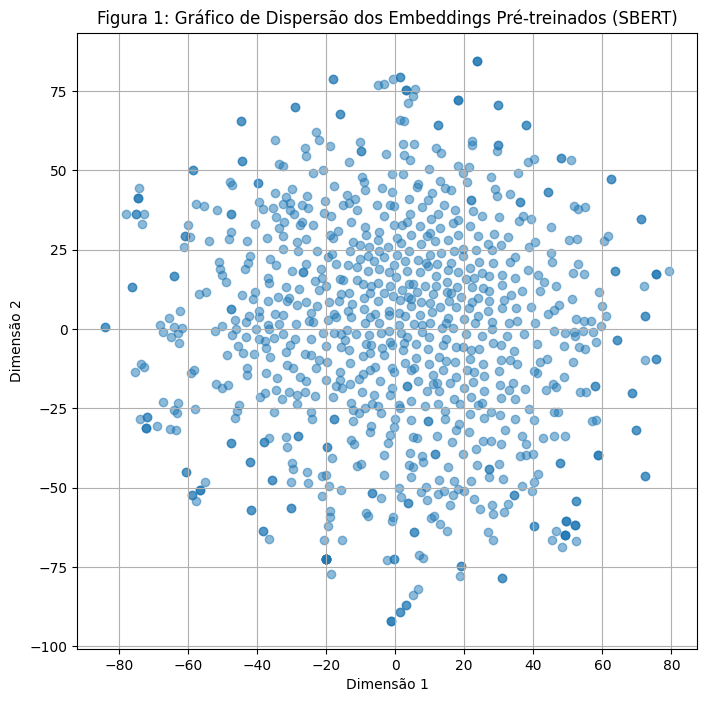

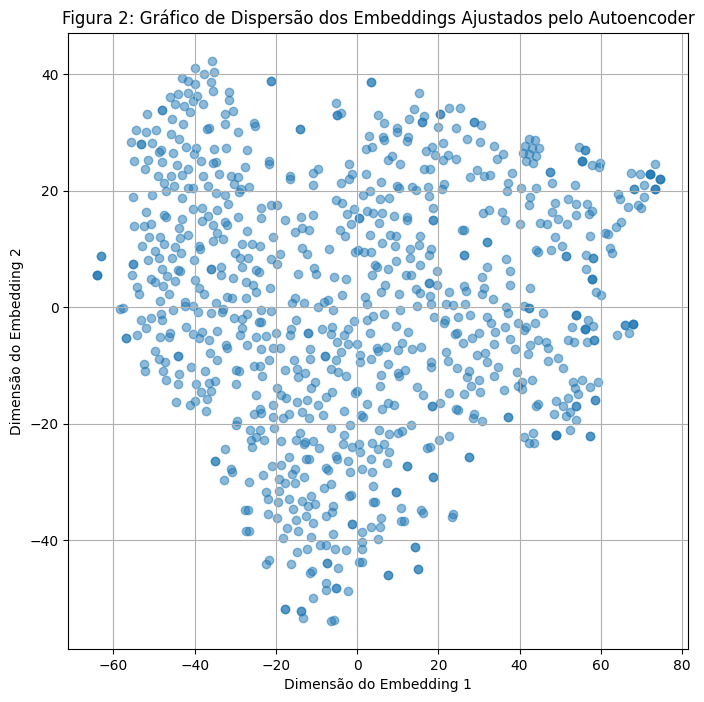

In [49]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch

# Carregar embeddings pré-treinados e ajustados
pretrained_embeddings = torch.load('sephora_embeddings.pt')  # Embeddings gerados com SBERT
fine_tuned_embeddings = np.load('fine_tuned_embeddings.npy')  # Embeddings ajustados pelo autoencoder

# Converter embeddings pré-treinados para NumPy para usar no TSNE
pretrained_embeddings_np = pretrained_embeddings.cpu().numpy()

# Reduzir a dimensionalidade dos embeddings pré-treinados com TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
pretrained_embeddings_2d = tsne.fit_transform(pretrained_embeddings_np)

# Reduzir a dimensionalidade dos embeddings ajustados com TSNE
fine_tuned_embeddings_2d = tsne.fit_transform(fine_tuned_embeddings)

# Figura 1: Visualizar os embeddings pré-treinados
plt.figure(figsize=(8, 8))
plt.scatter(pretrained_embeddings_2d[:, 0], pretrained_embeddings_2d[:, 1], alpha=0.5)
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.title('Figura 1: Gráfico de Dispersão dos Embeddings Pré-treinados (SBERT)')
plt.grid(True)
plt.show()

# Figura 2: Visualizar os embeddings ajustados
plt.figure(figsize=(8, 8))
plt.scatter(fine_tuned_embeddings_2d[:, 0], fine_tuned_embeddings_2d[:, 1], alpha=0.5)
plt.xlabel('Dimensão do Embedding 1')
plt.ylabel('Dimensão do Embedding 2')
plt.title('Figura 2: Gráfico de Dispersão dos Embeddings Ajustados pelo Autoencoder')
plt.grid(True)
plt.show()


In [61]:
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import torch
import pandas as pd

# Load pre-trained and fine-tuned embeddings
pretrained_embeddings = torch.load('sephora_embeddings.pt').cpu().numpy()
fine_tuned_embeddings = np.load('fine_tuned_embeddings.npy')

# Apply TSNE to both embeddings
tsne = TSNE(n_components=2, random_state=0, perplexity=40)
pretrained_tsne = tsne.fit_transform(pretrained_embeddings)
fine_tuned_tsne = tsne.fit_transform(fine_tuned_embeddings)

# Apply KMeans clustering for better insights into document organization
n_clusters = 5
kmeans_pretrained = KMeans(n_clusters=n_clusters, random_state=0).fit(pretrained_tsne)
kmeans_fine_tuned = KMeans(n_clusters=n_clusters, random_state=0).fit(fine_tuned_tsne)

# Load the dataset for labeling (assuming 'sephora_reviews.csv' with 'review_text' column exists)
sephora_data = pd.read_csv('sephora_reviews.csv')
sephora_data['pretrained_cluster'] = kmeans_pretrained.labels_
sephora_data['fine_tuned_cluster'] = kmeans_fine_tuned.labels_

# Plotting the TSNE results with Plotly for pre-trained embeddings
fig1 = px.scatter(
    x=pretrained_tsne[:, 0],
    y=pretrained_tsne[:, 1],
    color=sephora_data['pretrained_cluster'].astype(str),
    hover_data={'Review': sephora_data['Review']},
    labels={'color': 'Cluster'},
    title="Pre-trained Embeddings (TSNE Projection with Clusters)"
)
fig1.update_layout(
    width=600,  # Set figure width
    height=600,  # Set figure height
    xaxis_title="TSNE Dimension 1",
    yaxis_title="TSNE Dimension 2"
)
fig1.update_traces(marker=dict(size=5, opacity=0.7))  # Adjust marker size and opacity
fig1.show()

# Plotting the TSNE results with Plotly for fine-tuned embeddings
fig2 = px.scatter(
    x=fine_tuned_tsne[:, 0],
    y=fine_tuned_tsne[:, 1],
    color=sephora_data['fine_tuned_cluster'].astype(str),
    hover_data={'Review': sephora_data['Review']},
    labels={'color': 'Cluster'},
    title="Fine-tuned Embeddings (TSNE Projection with Clusters)"
)
fig2.update_layout(
    width=600,  # Set figure width
    height=600,  # Set figure height
    xaxis_title="TSNE Dimension 1",
    yaxis_title="TSNE Dimension 2"
)
fig2.update_traces(marker=dict(size=5, opacity=0.7))  # Adjust marker size and opacity
fig2.show()


<ipython-input-61-75957db8b7b1>:10: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

